## Imports

In [ ]:
import pandas as pd
from numpy import radians, sin, cos, arccos
import numpy as np
import time
from datetime import datetime
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from scipy import stats
import math
from zipfile import ZipFile
import datetime
data_path = 'data/'

### Helper functions

In [2]:
# Helper function which finds the distance between two points from their latitude and lonigutde coordinates
# It is used in the next parts

def find_distance(lat1, lat2, lon1, lon2):
    ### This fonction takes four columns of a dataframe and returns the column with all the distances
    ### calculated point by point.
    earth_radius = 6373 # In km
    lat1 = lat1/180 * math.pi
    lat2 = lat2/180 * math.pi
    dlat = lat2 - lat1
    dlon = (lon1 - lon2)/180 * math.pi
    a = (dlat/2).apply(math.sin)**2 + lat1.apply(math.cos) * lat2.apply(math.cos) * (dlon/2).apply(math.sin)**2
    c = 2 * (a.apply(math.sqrt) / (1 - a).apply(math.sqrt)).apply(math.atan)
    d = earth_radius * c
    distance_db = pd.DataFrame(d).rename(columns = {0 : 'distance'})
    return(distance_db)

# For each user, we want to assign them to one square (the one in which they checked-in the most).*
# In order to do so, we create a column named "my_square" which gives the name of the square in which each column
# is in. We take latitude = 0 and longitude = 0 to be the centre of the origin square.
# The names of our 25km * 25km squares are chosen as the tuple (latitude, longitude)

# In order to make our code more compact we create a function to create our labeling of squares.

def square_label(my_dataframe):
    inter = pd.DataFrame()
    cos_latitude = (my_dataframe['latitude']/180 * math.pi).apply(math.cos)
    inter["rounded_latitude"] = (110.574 * (my_dataframe['latitude'])/25).apply(round)
    inter["rounded_longitude"] = (111.320 * cos_latitude* (my_dataframe['longitude'])/25).apply(round)
    inter_list = inter.values.tolist()
    my_dataframe['my_square'] = [tuple(val) for val in inter_list]
    return(my_dataframe)

# For each user, we get the number of times where they checked in in a given location. We associate the position
# of their home with the position of the location where they checked in the most.

# In case of a draw (a user checked in the same number of times in two locations), we average the position of the
# house over the position of the most checked in locations.

# No need to re-run these lines if you have run the previous cells

def find_homes_avg(dataframe):
    grouped_data = dataframe.groupby(["user", "my_square"]).count()
    grouped_data = grouped_data.reset_index().drop(columns = ["locid"])
    # We start by getting all the values where there was a draw. (Takes a few minutes)
    # We then extract just the columns "user" and "my_square" to work on them.
    draw_data = grouped_data.groupby("user").apply(lambda x: x.loc[x["time"] == x["time"].max()])
    draw_value = pd.DataFrame(draw_data[["user", "my_square"]].values).rename(columns = {0 : 'user', 1 : 'my_square'})
    return(draw_value)

# Once we have filtered our home data, we can do our average over the right "my_square"
def compute_house_position(dataframe, home_data):
    dataframe = dataframe.merge(home_data, how = "inner", left_on = ["user", "my_square"], right_on = ["user", "my_square"])
    return(dataframe.groupby("user")[["latitude", "longitude"]].mean())

# At first, we think of doing a left join between gowalla_edges and our house position dataframe. We however realize
# that some users never checked in and therefore have no addresses.
# We therefore decide to do an inner join.

def join_homes_and_user(dataframe, home_data):
    first_join = dataframe.merge(home_data, left_on = "friend", right_on = "user").rename(columns = {"latitude" : "friend latitude", "longitude" : "friend longitude"})
    second_join = first_join.merge(home_data, left_on = "pal", right_on = "user").rename(columns = {"latitude" : "pal latitude", "longitude" : "pal longitude"})
    return(second_join)

In [4]:
df_friend = pd.read_csv(data_path+'dataset_WWW_friendship_new.txt', header = None, sep = "\t", names = ["friend", "pal"])
df_friend

,friend,pal
0,15,595326
1,19,54
2,19,1061
3,19,1668
4,19,21596
...,...,...
607328,2166684,2181580
607329,2167183,2175735
607330,2170360,2174239
607331,2173716,2186144


In [14]:
def distance_db_avg(dataframe):
    # loading the data
    checkins = pd.read_csv(data_path+dataframe, names=['locid','user', 'time','year',  'latitude', 'longitude', 'building', 'countries'],header=None, error_bad_lines=False)
    df_friend = pd.read_csv(data_path+'dataset_WWW_friendship_new.txt', header = None, sep = "\t", names = ["friend", "pal"])
    
    # convert string to number
    checkins.drop(0,0,inplace=True)
    checkins.user = checkins.user.astype(int)
    checkins.latitude = checkins.latitude.astype(float)
    checkins.longitude = checkins.longitude.astype(float)
    
    # Extracting useful informations (House location)
    checkins = square_label(checkins)
    home_data_avg = find_homes_avg(checkins)
    home_positions_avg = compute_house_position(checkins, home_data_avg)
    home_positions_avg = home_positions_avg.reset_index()
    
    # merge on the friend dataframe
    df_friend.merge(home_positions_avg, left_on = "friend", right_on = "user").merge(home_positions_avg, left_on = "pal", right_on = "user")
    friend_home_df_avg = join_homes_and_user(df_friend, home_positions_avg)
    distance_db_avg = find_distance(friend_home_df_avg["friend latitude"], friend_home_df_avg["pal latitude"], friend_home_df_avg["friend longitude"], friend_home_df_avg["pal longitude"])
    return distance_db_avg

In [15]:
US_distance_db_avg  = distance_db_avg('1_US_2013_merge_data.csv')
PH_distance_db_avg  = distance_db_avg('10_PH_2013_merge_data.csv')
ID_distance_db_avg  = distance_db_avg('2_ID_2013_merge_data.csv')
TR_distance_db_avg  = distance_db_avg('4_TR_2013_merge_data.csv')
RU_distance_db_avg  = distance_db_avg('5_RU_2013_merge_data.csv')
JP_distance_db_avg  = distance_db_avg('6_JP_2013_merge_data.csv')
MY_distance_db_avg  = distance_db_avg('7_MY_2013_merge_data.csv')
MX_distance_db_avg  = distance_db_avg('8_MX_2013_merge_data.csv')
TH_distance_db_avg  = distance_db_avg('9_TH_2013_merge_data.csv')


C:\Users\Marion Chabrier\.julia\conda\3\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (1,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\Marion Chabrier\.julia\conda\3\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (1,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\Marion Chabrier\.julia\conda\3\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (1,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\Marion Chabrier\.julia\conda\3\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (1,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(c

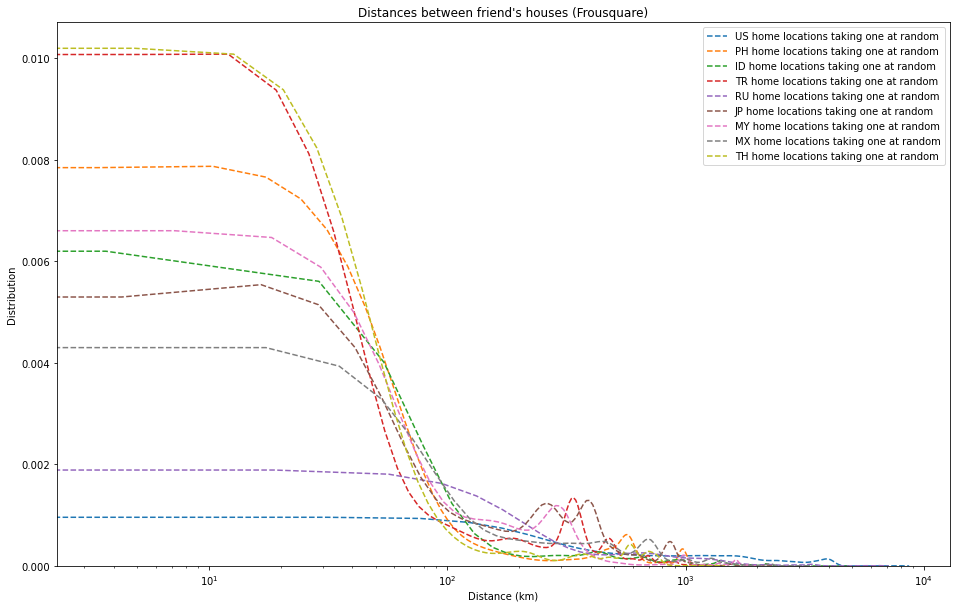

In [13]:
# We compare the distance between houses with our two dataframes of houses locations.

fig, ax = plt.subplots(figsize = (16, 10))
sns.kdeplot(US_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'US home locations taking one at random')
sns.kdeplot(PH_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'PH home locations taking one at random')
sns.kdeplot(ID_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'ID home locations taking one at random')
sns.kdeplot(TR_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'TR home locations taking one at random')
sns.kdeplot(RU_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'RU home locations taking one at random')
sns.kdeplot(JP_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'JP home locations taking one at random')
sns.kdeplot(MY_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'MY home locations taking one at random')
sns.kdeplot(MX_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'MX home locations taking one at random')
sns.kdeplot(TH_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'TH home locations taking one at random')
plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")
plt.title("Distances between friend's houses (Frousquare)")
plt.ylabel("Distribution")
plt.xlabel("Distance (km)")
ax.legend()
plt.show()